<a href="https://colab.research.google.com/github/dinagalevska/DrugCombDeepLearning/blob/master/Models_and_RocAUC_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train and Eval GNN

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, start, to):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

        self.start = start
        self.to = to

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict[self.start][row], z_dict[self.to][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
  def __init__(self, hidden_channels, data, start, to):
      super().__init__()
      self.encoder = GNNEncoder(hidden_channels, hidden_channels)
      self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
      self.decoder = EdgeDecoder(hidden_channels=hidden_channels, start=start, to=to)

  def forward(self, x_dict, edge_index_dict, edge_label_index):
      z_dict = self.encoder(x_dict, edge_index_dict)
      return self.decoder(z_dict, edge_label_index)


In [ ]:
def train_link_prediction(model, train_data, val_data, optimizer, loss_fn, start, to, epochs=5):
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                     train_data[start,'interacts_with', to].edge_label_index)

        target = train_data[start,'interacts_with', to].edge_label
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.inference_mode():
          pred = model(val_data.x_dict, val_data.edge_index_dict,
                      val_data[start,'interacts_with', to].edge_label_index)
        pred = pred.clamp(min=0, max=1)
        target = val_data[start,'interacts_with', to].edge_label.float()
        val_loss = loss_fn(pred, target)
        if epoch % 50 == 0:
          print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

In [ ]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    sns.set(style="whitegrid")

    plt.figure(figsize=(5, 5))

    plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')

    plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)

    # plt.legend(loc="lower right", fontsize=12)

    sns.despine()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    plt.show()

In [ ]:
def test_link_prediction(model, test_data, loss_fn, start, to):
    model = model.to(device)

    model.eval()

    with torch.inference_mode():
        pred = model(test_data.x_dict, test_data.edge_index_dict,
                     test_data[start, 'interacts_with', to].edge_label_index)

    pred = pred.clamp(min=0, max=1)

    target = test_data[start, 'interacts_with', to].edge_label.float()

    y_true = target.cpu().numpy()
    y_pred = pred.detach().cpu().numpy()

    val_loss = loss_fn(pred, target)
    print(f'Loss: {val_loss:.4f}')

    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'ROC AUC Score: {roc_auc:.4f}')

    y_pred_rounded = (y_pred >= 0.5).astype(int)
    print(classification_report(y_true=y_true, y_pred=y_pred_rounded, digits=4))

    return y_true, y_pred


In [ ]:
start, forward_relation, to = 'drug', 'interacts_with', 'drug'


train_val_test_split = RandomLinkSplit(num_val=0.1,
                                      num_test=0.3,
                                      add_negative_train_samples=True,
                                      is_undirected=False,
                                      neg_sampling_ratio=1.0,
                                      edge_types=(start, forward_relation, to),
                                      rev_edge_types=(start, forward_relation, to)
                                      )

In [ ]:
train_data, val_data, test_data = train_val_test_split(hetero_data)

In [ ]:
model = Model(hidden_channels=128, data=hetero_data, start=start, to=to)
optimizer = SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

In [ ]:
train_link_prediction(model.to(device), train_data.to(device), val_data.to(device), optimizer, loss_fn, start, to, 400)

Epoch: 000, Loss: 0.5126, Val Loss: 0.4579
Epoch: 050, Loss: 0.0179, Val Loss: 0.0839
Epoch: 100, Loss: 0.0046, Val Loss: 0.0813
Epoch: 150, Loss: 0.0021, Val Loss: 0.0800
Epoch: 200, Loss: 0.0014, Val Loss: 0.0796
Epoch: 250, Loss: 0.0012, Val Loss: 0.0794
Epoch: 300, Loss: 0.0010, Val Loss: 0.0792
Epoch: 350, Loss: 0.0008, Val Loss: 0.0792
Epoch: 399, Loss: 0.0007, Val Loss: 0.0792


In [ ]:
y_true, y_pred = test_link_prediction(model=model, test_data=test_data.to(device), start=start, to=to, loss_fn=loss_fn)

Loss: 0.0835
ROC AUC Score: 0.9496
              precision    recall  f1-score   support

         0.0     0.8409    1.0000    0.9136        37
         1.0     1.0000    0.8108    0.8955        37

    accuracy                         0.9054        74
   macro avg     0.9205    0.9054    0.9046        74
weighted avg     0.9205    0.9054    0.9046        74



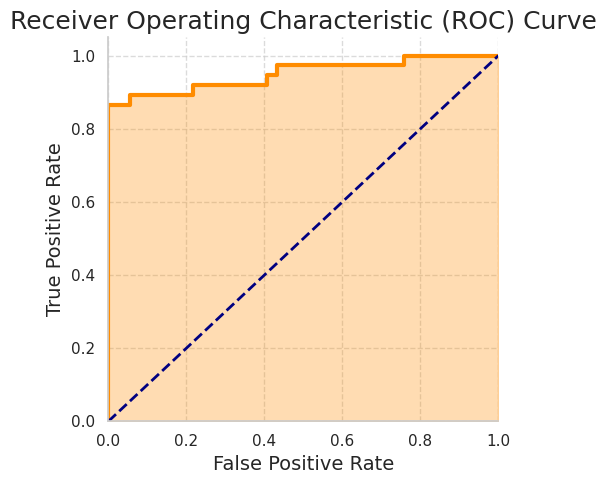

In [ ]:
plot_roc_curve(y_true, y_pred)

##*LigntGCN*

In [ ]:
def train_lightgcn(data, data_loader, model, optimizer, num_drugs, epochs=10, patience=2):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss, total_examples = 0, 0

        for iteration, node_ids in enumerate(data_loader):
            pos_edge_label_index = data.edge_index[:, node_ids]
            generated = torch.randint(0, num_drugs, (node_ids.numel(),)).to(device)

            generated = torch.clamp(generated, 0, num_drugs - 1)

            neg_edge_label_index = torch.stack([pos_edge_label_index[0], generated], dim=0)
            edge_label_index = torch.cat([pos_edge_label_index, neg_edge_label_index], dim=1)

            if edge_label_index.max() >= num_drugs:
                print(f"Warning: Index out of bounds detected in edge_label_index with max value {edge_label_index.max()}")

            optimizer.zero_grad()

            pos_rank, neg_rank = model(data.edge_index.to(device), edge_label_index.to(device)).chunk(2)

            loss = model.recommendation_loss(pos_rank, neg_rank, node_id=edge_label_index.unique())
            loss.backward()
            optimizer.step()

            total_loss += float(loss) * pos_rank.numel()
            total_examples += pos_rank.numel()

        avg_loss = total_loss / total_examples
        print(f'Epoch: {epoch:03d}, Loss: {avg_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    return best_loss


In [ ]:
hetero_data

HeteroData(
  drug={ x=[17614, 768] },
  (drug, interacts_with, drug)={ edge_index=[2, 125] }
)

In [ ]:
num_drugs = hetero_data.num_nodes

In [ ]:
homogenous = hetero_data.to_homogeneous()

In [ ]:
homogenous

Data(edge_index=[2, 125], x=[17614, 768], node_type=[17614], edge_type=[125])

In [ ]:
homogenous.to(device)

Data(edge_index=[2, 125], x=[17614, 768], node_type=[17614], edge_type=[125])

In [ ]:
train_test_split = RandomLinkSplit(num_val=0.2,
                                           num_test=0.1)
train_data, val_data, test_data = train_test_split(homogenous)

In [ ]:
param_grid = {
    'batch_size': [2, 4, 8],
    'embedding_dim': [32, 64, 128],
    'lr': [0.01, 0.001],
    'num_layers': [2, 3, 4]
}

combinations = list(itertools.product(*param_grid.values()))

In [ ]:
def grid_search(train_data, homogenous, num_drugs, param_combinations):
    best_params = None
    best_loss = float('inf')

    for params in param_combinations:
        batch_size, embedding_dim, lr, num_layers = params

        train_loader = DataLoader(range(train_data.edge_index.size(1)), shuffle=True, batch_size=batch_size)

        model = LightGCNModel(num_nodes=num_drugs, embedding_dim=embedding_dim, num_layers=num_layers)

        optimizer = SGD(model.parameters(), lr=lr)

        train_loss = train_lightgcn(homogenous, train_loader, model, optimizer, num_drugs, epochs=100)

        if train_loss < best_loss:
            best_loss = train_loss
            best_params = params

    return best_params, best_loss


In [ ]:
best_params, best_loss = grid_search(train_data, homogenous, num_drugs, combinations)

print("Best Parameters: ", dict(zip(param_grid.keys(), best_params)))
print("Best Loss: ", best_loss)


Epoch: 000, Loss: 0.6930
Epoch: 001, Loss: 0.6930
Epoch: 002, Loss: 0.6930
Epoch: 003, Loss: 0.6930
Epoch: 004, Loss: 0.6930
Epoch: 005, Loss: 0.6930
Epoch: 006, Loss: 0.6930
Epoch: 007, Loss: 0.6930
Epoch: 008, Loss: 0.6930
Epoch: 009, Loss: 0.6929
Epoch: 010, Loss: 0.6929
Epoch: 011, Loss: 0.6929
Epoch: 012, Loss: 0.6929
Epoch: 013, Loss: 0.6929
Epoch: 014, Loss: 0.6929
Epoch: 015, Loss: 0.6929
Epoch: 016, Loss: 0.6929
Epoch: 017, Loss: 0.6929
Epoch: 018, Loss: 0.6929
Epoch: 019, Loss: 0.6928
Epoch: 020, Loss: 0.6928
Epoch: 021, Loss: 0.6928
Epoch: 022, Loss: 0.6928
Epoch: 023, Loss: 0.6928
Epoch: 024, Loss: 0.6928
Epoch: 025, Loss: 0.6927
Epoch: 026, Loss: 0.6927
Epoch: 027, Loss: 0.6927
Epoch: 028, Loss: 0.6927
Epoch: 029, Loss: 0.6927
Epoch: 030, Loss: 0.6926
Epoch: 031, Loss: 0.6926
Epoch: 032, Loss: 0.6926
Epoch: 033, Loss: 0.6926
Epoch: 034, Loss: 0.6925
Epoch: 035, Loss: 0.6925
Epoch: 036, Loss: 0.6925
Epoch: 037, Loss: 0.6925
Epoch: 038, Loss: 0.6924
Epoch: 039, Loss: 0.6924


In [ ]:
batch_size, embedding_dim, lr, num_layers = best_params

train_loader = DataLoader(range(train_data.edge_index.size(1)), shuffle=True, batch_size=batch_size)

model = LightGCNModel(num_nodes=num_drugs, embedding_dim=embedding_dim, num_layers=num_layers)

optimizer = SGD(model.parameters(), lr=lr)

train_lightgcn(homogenous, train_loader, model, optimizer, num_drugs, epochs=200)

Epoch: 000, Loss: 0.6926
Epoch: 001, Loss: 0.6925
Epoch: 002, Loss: 0.6925
Epoch: 003, Loss: 0.6925
Epoch: 004, Loss: 0.6924
Epoch: 005, Loss: 0.6924
Epoch: 006, Loss: 0.6924
Epoch: 007, Loss: 0.6924
Epoch: 008, Loss: 0.6923
Epoch: 009, Loss: 0.6923
Epoch: 010, Loss: 0.6923
Epoch: 011, Loss: 0.6922
Epoch: 012, Loss: 0.6921
Epoch: 013, Loss: 0.6921
Epoch: 014, Loss: 0.6920
Epoch: 015, Loss: 0.6920
Epoch: 016, Loss: 0.6919
Epoch: 017, Loss: 0.6919
Epoch: 018, Loss: 0.6918
Epoch: 019, Loss: 0.6918
Epoch: 020, Loss: 0.6917
Epoch: 021, Loss: 0.6916
Epoch: 022, Loss: 0.6915
Epoch: 023, Loss: 0.6915
Epoch: 024, Loss: 0.6914
Epoch: 025, Loss: 0.6913
Epoch: 026, Loss: 0.6912
Epoch: 027, Loss: 0.6911
Epoch: 028, Loss: 0.6910
Epoch: 029, Loss: 0.6909
Epoch: 030, Loss: 0.6908
Epoch: 031, Loss: 0.6907
Epoch: 032, Loss: 0.6906
Epoch: 033, Loss: 0.6905
Epoch: 034, Loss: 0.6903
Epoch: 035, Loss: 0.6902
Epoch: 036, Loss: 0.6901
Epoch: 037, Loss: 0.6899
Epoch: 038, Loss: 0.6898
Epoch: 039, Loss: 0.6896


0.27717657133259554

In [ ]:
test_loader = DataLoader(range(test_data.edge_index.size(1)),
                             shuffle=True,
                             batch_size=2)

In [ ]:
def plot_roc_curve(y_true, y_scores):

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    sns.set(style="whitegrid")

    plt.figure(figsize=(6, 5))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2, label='Random Guess')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # plt.legend(loc='lower right', fontsize=12)

    plt.tight_layout()

    plt.show()

def test_lightgcn(model, test_loader, hetero_data, num_drugs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    all_true_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, tuple):
                batch = batch[0]

            node_ids = batch.to(device)

            pos_edge_label_index = hetero_data['drug', 'interacts_with', 'drug'].edge_index
            num_edges = pos_edge_label_index.size(1)

            generated = torch.randint(0, num_drugs, (num_edges,), dtype=torch.long).to(device)
            neg_edge_label_index = torch.stack([pos_edge_label_index[0], generated], dim=0)
            edge_label_index = torch.cat([pos_edge_label_index, neg_edge_label_index], dim=1)

            pos_scores, neg_scores = model(hetero_data['drug', 'interacts_with', 'drug'].edge_index.to(device), edge_label_index.to(device)).chunk(2)

            true_labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))], dim=0)
            pred_scores = torch.cat([pos_scores, neg_scores], dim=0).sigmoid()

            all_true_labels.extend(true_labels.cpu().numpy())
            all_pred_scores.extend(pred_scores.cpu().numpy())

    y_true = np.array(all_true_labels)
    y_pred = [1 if score >= 0.5 else 0 for score in all_pred_scores]

    print(classification_report(y_true, y_pred, digits=4))
    roc_auc = roc_auc_score(y_true, all_pred_scores)
    print(f'ROC AUC: {roc_auc:.4f}')


    plot_roc_curve(y_true, all_pred_scores)



              precision    recall  f1-score   support

         0.0     1.0000    0.5039    0.6701      7125
         1.0     0.6684    1.0000    0.8012      7125

    accuracy                         0.7519     14250
   macro avg     0.8342    0.7519    0.7357     14250
weighted avg     0.8342    0.7519    0.7357     14250

ROC AUC: 0.9721


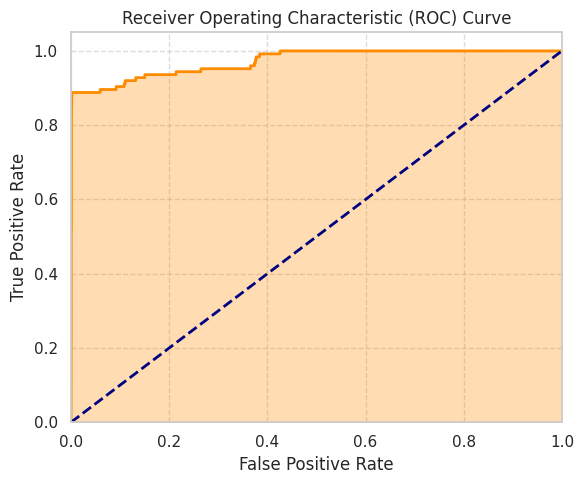

In [ ]:
test_lightgcn(model.to(device), test_loader, hetero_data.to(device), num_drugs)